In [227]:
import pandas as pd
import numpy as np
from pycaret.regression import *

# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)

In [228]:
Q1 = df['W_LEV_AVG'].quantile(0.25)
Q3 = df['W_LEV_AVG'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['W_LEV_AVG'] >= Q1 - 1.5 * IQR) & (df['W_LEV_AVG'] <= Q3 + 1.5 * IQR)]
df

,W_LEV_AVG,dayofweek,month,day,hour
DATE,,,,,
2013-10-01 07:00:00,0.4129,1,10,1,7
2013-10-01 07:10:00,0.4528,1,10,1,7
2013-10-01 07:20:00,0.4901,1,10,1,7
2013-10-01 07:30:00,0.5079,1,10,1,7
2013-10-01 07:40:00,0.5468,1,10,1,7
...,...,...,...,...,...
2023-12-31 23:10:00,0.3508,6,12,31,23
2023-12-31 23:20:00,0.4242,6,12,31,23
2023-12-31 23:30:00,0.4790,6,12,31,23


In [229]:
import ephem
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df["full_moon_days"] = (df["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df["dark_moon_days"] = (df["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [230]:
compare_data = df[-432:]
df = df[:-432]
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 18 (3 hour)
    compare_data[f'W_LEV_AVG_lag_{lag}'] = compare_data['W_LEV_AVG'].shift(lag)

compare_data.dropna(inplace=True)
compare_data

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,...,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18
DATE,,,,,,,,,,,,,,,,,,,,,
2023-12-29 03:00:00,-0.6634,4,12,29,3,95,0,0,-0.5485,-0.4397,...,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828,0.8169,0.8538
2023-12-29 03:10:00,-0.7622,4,12,29,3,95,0,0,-0.6634,-0.5485,...,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828,0.8169
2023-12-29 03:20:00,-0.8795,4,12,29,3,95,0,0,-0.7622,-0.6634,...,0.0978,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828
2023-12-29 03:30:00,-0.9905,4,12,29,3,95,0,0,-0.8795,-0.7622,...,-0.0022,0.0978,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259
2023-12-29 03:40:00,-1.0927,4,12,29,3,95,0,0,-0.9905,-0.8795,...,-0.1052,-0.0022,0.0978,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,0.3508,6,12,31,23,78,0,0,0.2852,0.2054,...,-0.3465,-0.4355,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627,-0.9220,-0.9874
2023-12-31 23:20:00,0.4242,6,12,31,23,78,0,0,0.3508,0.2852,...,-0.2573,-0.3465,-0.4355,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627,-0.9220
2023-12-31 23:30:00,0.4790,6,12,31,23,78,0,0,0.4242,0.3508,...,-0.1770,-0.2573,-0.3465,-0.4355,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627


In [231]:
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 18 (3 hour)
    df[f'W_LEV_AVG_lag_{lag}'] = df['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df.dropna(inplace=True)
df

,W_LEV_AVG,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,...,W_LEV_AVG_lag_9,W_LEV_AVG_lag_10,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18
DATE,,,,,,,,,,,,,,,,,,,,,
2013-10-01 10:00:00,0.3375,1,10,1,10,14,0,0,0.3896,0.4324,...,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901,0.4528,0.4129
2013-10-01 10:10:00,0.2846,1,10,1,10,14,0,0,0.3375,0.3896,...,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901,0.4528
2013-10-01 10:20:00,0.2276,1,10,1,10,14,0,0,0.2846,0.3375,...,0.5575,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901
2013-10-01 10:30:00,0.1704,1,10,1,10,13,0,0,0.2276,0.2846,...,0.5500,0.5575,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079
2013-10-01 10:40:00,0.1157,1,10,1,10,13,0,0,0.1704,0.2276,...,0.5222,0.5500,0.5575,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 23:10:00,0.8914,3,12,28,23,96,0,0,0.8763,0.8404,...,0.3855,0.3083,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607,-0.3692,-0.4605
2023-12-28 23:20:00,0.9097,3,12,28,23,96,0,0,0.8914,0.8763,...,0.4866,0.3855,0.3083,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607,-0.3692
2023-12-28 23:30:00,0.9084,3,12,28,23,96,0,0,0.9097,0.8914,...,0.5650,0.4866,0.3855,0.3083,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607


In [147]:
exp = setup(data=df, target='W_LEV_AVG', fold=10, train_size=0.8, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,W_LEV_AVG
2,Target type,Regression
3,Original data shape,"(400540, 26)"
4,Transformed data shape,"(384518, 26)"
5,Transformed train set shape,"(304410, 26)"
6,Transformed test set shape,"(80108, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [148]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0127,0.0008,0.0272,0.9988,0.0159,0.0912,3.0090
ridge,Ridge Regression,0.0127,0.0008,0.0273,0.9988,0.0159,0.0912,3.2720
br,Bayesian Ridge,0.0127,0.0008,0.0272,0.9988,0.0159,0.0912,4.1270
et,Extra Trees Regressor,0.0119,0.0007,0.0266,0.9988,0.0154,0.0820,45.8320
rf,Random Forest Regressor,0.0126,0.0009,0.0305,0.9985,0.0170,0.0840,115.6830
lightgbm,Light Gradient Boosting Machine,0.0153,0.0010,0.0309,0.9984,0.0176,0.1031,5.5860
gbr,Gradient Boosting Regressor,0.0193,0.0013,0.0360,0.9978,0.0219,0.1351,183.8270
dt,Decision Tree Regressor,0.0176,0.0017,0.0409,0.9972,0.0227,0.1177,15.6540
par,Passive Aggressive Regressor,0.0378,0.0027,0.0516,0.9955,0.0318,0.2642,3.9220
huber,Huber Regressor,0.0387,0.0048,0.0690,0.9921,0.0409,0.2683,12.3700


In [252]:
best_model = create_model('et')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:43:05
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [233]:
compare_prediction = exp.predict_model(best_model, data=compare_data)
compare_prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0132,0.0003,0.0162,0.9995,0.0101,0.0609


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2023-12-29 03:00:00,4,12,29,3,95,0,0,-0.5485,-0.4397,-0.3273,...,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828,0.8169,0.8538,-0.6634,-0.655454
2023-12-29 03:10:00,4,12,29,3,95,0,0,-0.6634,-0.5485,-0.4397,...,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828,0.8169,-0.7622,-0.765626
2023-12-29 03:20:00,4,12,29,3,95,0,0,-0.7622,-0.6634,-0.5485,...,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,0.7828,-0.8795,-0.861801
2023-12-29 03:30:00,4,12,29,3,95,0,0,-0.8795,-0.7622,-0.6634,...,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,0.7259,-0.9905,-0.966176
2023-12-29 03:40:00,4,12,29,3,95,0,0,-0.9905,-0.8795,-0.7622,...,0.0978,0.1973,0.2917,0.3696,0.4609,0.5445,0.6053,0.6723,-1.0927,-1.080737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,6,12,31,23,78,0,0,0.2852,0.2054,0.1213,...,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627,-0.9220,-0.9874,0.3508,0.360075
2023-12-31 23:20:00,6,12,31,23,78,0,0,0.3508,0.2852,0.2054,...,-0.4355,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627,-0.9220,0.4242,0.413450
2023-12-31 23:30:00,6,12,31,23,78,0,0,0.4242,0.3508,0.2852,...,-0.3465,-0.4355,-0.5201,-0.6000,-0.6651,-0.7272,-0.7966,-0.8627,0.4790,0.486030


In [234]:
prediction = exp.predict_model(best_model, data=df)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0153,0.0009,0.0308,0.9984,0.0176,0.1002


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2013-10-01 10:00:00,1,10,1,10,14,0,0,0.3896,0.4324,0.4690,...,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901,0.4528,0.4129,0.3375,0.338574
2013-10-01 10:10:00,1,10,1,10,14,0,0,0.3375,0.3896,0.4324,...,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901,0.4528,0.2846,0.283875
2013-10-01 10:20:00,1,10,1,10,14,0,0,0.2846,0.3375,0.3896,...,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.4901,0.2276,0.230873
2013-10-01 10:30:00,1,10,1,10,13,0,0,0.2276,0.2846,0.3375,...,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.5079,0.1704,0.163641
2013-10-01 10:40:00,1,10,1,10,13,0,0,0.1704,0.2276,0.2846,...,0.5575,0.5802,0.5796,0.5914,0.5791,0.5775,0.5645,0.5468,0.1157,0.096711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 23:10:00,3,12,28,23,96,0,0,0.8763,0.8404,0.8163,...,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607,-0.3692,-0.4605,0.8914,0.918967
2023-12-28 23:20:00,3,12,28,23,96,0,0,0.8914,0.8763,0.8404,...,0.3083,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607,-0.3692,0.9097,0.928648
2023-12-28 23:30:00,3,12,28,23,96,0,0,0.9097,0.8914,0.8763,...,0.3855,0.3083,0.2271,0.1334,0.0397,-0.0572,-0.1637,-0.2607,0.9084,0.930683


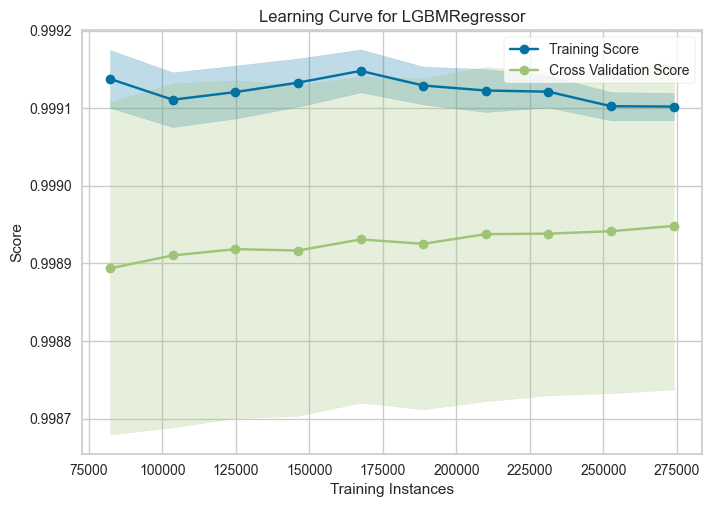

In [235]:
plot_model(best_model, plot='learning')

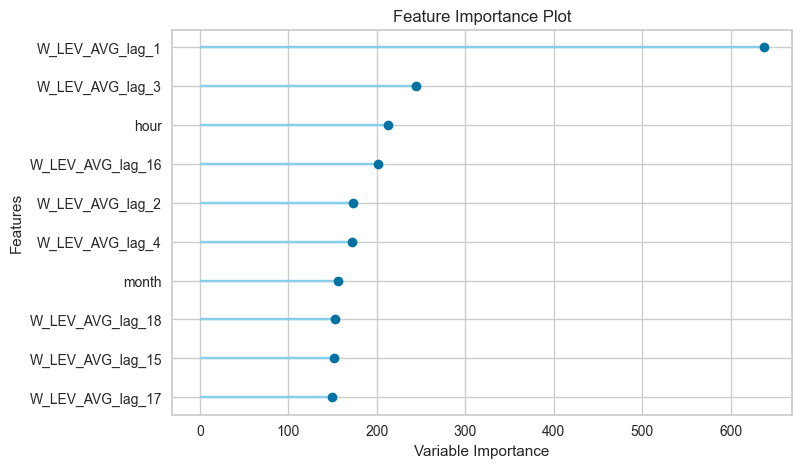

In [236]:
plot_model(best_model, plot='feature')

เทสกับข้อมูลอื่นในหลัก 10 นาที 1 ชั่วโมง และ 1 วันตามลำดับ

In [237]:
import pandas as pd
import numpy as np
from pycaret.regression import *
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df_test = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-chompon-tidegauge-2016_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df_test["DATE"] = df_test["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df_test["DATE"] = df_test["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df_test["DATE"] = pd.to_datetime(df_test["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df_test.set_index('DATE', inplace=True)
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['hour'] = df_test.index.hour
df_test = df_test.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df_test

,W_LEV_AVG,dayofweek,month,day,hour
DATE,,,,,
2016-07-22 07:00:00,-0.7662,4,7,22,7
2016-07-22 07:10:00,-0.7625,4,7,22,7
2016-07-22 07:20:00,-0.7778,4,7,22,7
2016-07-22 07:30:00,-0.8250,4,7,22,7
2016-07-22 07:40:00,-0.8593,4,7,22,7
...,...,...,...,...,...
2023-12-31 23:10:00,-0.3997,6,12,31,23
2023-12-31 23:20:00,-0.3979,6,12,31,23
2023-12-31 23:30:00,-0.3970,6,12,31,23


In [238]:
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df_test["moon_phase"] = df_test.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df_test["full_moon_days"] = (df_test["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df_test["dark_moon_days"] = (df_test["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [239]:
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test[f'W_LEV_AVG_lag_{lag}'] = df_test['W_LEV_AVG'].shift(lag)

# Drop NaN values caused by shifting
df_test.dropna(inplace=True)

In [240]:
test_prediction_m = exp.predict_model(best_model, data=df_test)
test_prediction_m

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0288,0.0012,0.0346,0.9949,0.0241,0.3752


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-22 10:00:00,4,7,22,10,93,0,0,-0.9173,-0.9125,-0.8918,...,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.7625,-0.7662,-0.8955,-0.865916
2016-07-22 10:10:00,4,7,22,10,93,0,0,-0.8955,-0.9173,-0.9125,...,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.7625,-0.8758,-0.840880
2016-07-22 10:20:00,4,7,22,10,93,0,0,-0.8758,-0.8955,-0.9173,...,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.7778,-0.8768,-0.822869
2016-07-22 10:30:00,4,7,22,10,93,0,0,-0.8768,-0.8758,-0.8955,...,-0.8944,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8250,-0.8683,-0.822869
2016-07-22 10:40:00,4,7,22,10,93,0,0,-0.8683,-0.8768,-0.8758,...,-0.8905,-0.8944,-0.8969,-0.8855,-0.8674,-0.8717,-0.8612,-0.8593,-0.8604,-0.809049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:10:00,6,12,31,23,78,0,0,-0.3997,-0.3846,-0.3797,...,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.1355,-0.1111,-0.3997,-0.421837
2023-12-31 23:20:00,6,12,31,23,78,0,0,-0.3997,-0.3997,-0.3846,...,-0.2803,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.1355,-0.3979,-0.421837
2023-12-31 23:30:00,6,12,31,23,78,0,0,-0.3979,-0.3997,-0.3997,...,-0.3030,-0.2803,-0.2651,-0.2469,-0.2201,-0.1949,-0.1731,-0.1539,-0.3970,-0.410639


In [241]:
df_test_h = df_test.resample("h").mean()
df_test_h.dropna(inplace=True)

# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test_h[f'W_LEV_AVG_lag_{lag}'] = df_test_h['W_LEV_AVG'].shift(lag)
df_test_h.dropna(inplace=True)

test_prediction_h = exp.predict_model(best_model, data=df_test_h)
test_prediction_h

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1092,0.0173,0.1314,0.9257,0.0899,2.0468


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-07-23 04:00:00,5.0,7.0,23.0,4.0,88.000000,0.0,0.0,0.307333,0.509617,0.637950,...,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.871017,0.021067,0.296895
2016-07-23 05:00:00,5.0,7.0,23.0,5.0,88.000000,0.0,0.0,0.021067,0.307333,0.509617,...,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.823017,-0.226000,-0.080451
2016-07-23 06:00:00,5.0,7.0,23.0,6.0,87.166664,0.0,0.0,-0.226000,0.021067,0.307333,...,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.792517,-0.454333,-0.379808
2016-07-23 07:00:00,5.0,7.0,23.0,7.0,87.000000,0.0,0.0,-0.454333,-0.226000,0.021067,...,-0.016017,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.717783,-0.614567,-0.390166
2016-07-23 08:00:00,5.0,7.0,23.0,8.0,87.000000,0.0,0.0,-0.614567,-0.454333,-0.226000,...,0.214950,-0.016017,-0.196950,-0.328733,-0.425967,-0.506700,-0.571750,-0.638933,-0.744100,-0.504012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,6.0,12.0,31.0,19.0,79.500000,0.0,0.0,0.256650,0.498333,0.759050,...,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.271000,-0.344250,0.036850,-0.024557
2023-12-31 20:00:00,6.0,12.0,31.0,20.0,79.000000,0.0,0.0,0.036850,0.256650,0.498333,...,0.642400,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.271000,-0.141900,-0.050149
2023-12-31 21:00:00,6.0,12.0,31.0,21.0,79.000000,0.0,0.0,-0.141900,0.036850,0.256650,...,0.889250,0.642400,0.408083,0.209600,0.064233,-0.052000,-0.140717,-0.209483,-0.272483,-0.241888


In [242]:
df_test_d = df_test.resample("D").mean()
df_test_d.dropna(inplace=True)
# Create lag features for the past 14 days
for lag in range(1, 19):  # Lags from 1 to 14 days
    df_test_d[f'W_LEV_AVG_lag_{lag}'] = df_test_d['W_LEV_AVG'].shift(lag)
df_test_d.dropna(inplace=True)
test_prediction_d = exp.predict_model(best_model, data=df_test_d)
test_prediction_d

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0826,0.0132,0.1149,0.7711,0.0837,1.6573


,dayofweek,month,day,hour,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_lag_1,W_LEV_AVG_lag_2,W_LEV_AVG_lag_3,...,W_LEV_AVG_lag_11,W_LEV_AVG_lag_12,W_LEV_AVG_lag_13,W_LEV_AVG_lag_14,W_LEV_AVG_lag_15,W_LEV_AVG_lag_16,W_LEV_AVG_lag_17,W_LEV_AVG_lag_18,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,,,,,,,,,,
2016-08-09,1.0,8.0,9.0,11.5,38.215279,0.0,0.0,-0.435174,-0.461972,-0.357922,...,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.269145,-0.333580,-0.404411,-0.417766
2016-08-10,2.0,8.0,10.0,11.5,47.583332,0.0,0.0,-0.404411,-0.435174,-0.461972,...,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.269145,-0.501238,-0.414057
2016-08-11,3.0,8.0,11.0,11.5,57.069443,0.0,0.0,-0.501238,-0.404411,-0.435174,...,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.347915,-0.575842,-0.487823
2016-08-12,4.0,8.0,12.0,11.5,66.395836,0.0,0.0,-0.575842,-0.501238,-0.404411,...,-0.472896,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.262940,-0.452125,-0.553355
2016-08-13,5.0,8.0,13.0,11.5,75.236115,0.0,0.0,-0.452125,-0.575842,-0.501238,...,-0.560056,-0.472896,-0.374085,-0.347185,-0.343085,-0.288399,-0.335149,-0.416648,-0.503794,-0.459493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2.0,12.0,27.0,11.5,99.576385,0.0,0.0,0.650602,0.610687,0.538469,...,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.182337,0.212726,0.479415,0.629889
2023-12-28,3.0,12.0,28.0,11.5,97.548615,0.0,0.0,0.479415,0.650602,0.610687,...,0.405360,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.182337,0.411685,0.391010
2023-12-29,4.0,12.0,29.0,11.5,93.798615,0.0,0.0,0.411685,0.479415,0.650602,...,0.452292,0.405360,0.255712,0.264506,0.315138,0.280124,0.270866,0.200095,0.377428,0.369154


วัดความแม่นยำโดยใช้ MAE

In [243]:
#compare_data 30 index
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)  # Last 7 known values

# Extract actual values and predicted values
y_true = compare_data["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0132,0.0003,0.0162,0.9995,0.0101,0.0609


R² Score: 0.9995
Mean Absolute Error (MAE): 0.0132
Root Mean Squared Error (RMSE): 0.0162
Accuracy: 100.00%


In [244]:
# Train Data 
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)  # Last 7 known values

# Extract actual values and predicted values
y_true = df["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0153,0.0009,0.0308,0.9984,0.0176,0.1002


R² Score: 0.9984
Mean Absolute Error (MAE): 0.0153
Root Mean Squared Error (RMSE): 0.0308
Accuracy: 100.00%


In [245]:
# Other file test data
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)  # Last 7 known values

# Extract actual values and predicted values
y_true = df_test["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = max(0, min(100, (1 - (mae / mean_actual)) * 100))  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0288,0.0012,0.0346,0.9949,0.0241,0.3752


R² Score: 0.9949
Mean Absolute Error (MAE): 0.0288
Root Mean Squared Error (RMSE): 0.0346
Accuracy: 35.75%


วัดความแม่นยำโดยใช้ MAPE

In [246]:
#compare_data 30 index
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)

# Extract actual values and predicted values
y_true = compare_data["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0132,0.0003,0.0162,0.9995,0.0101,0.0609


R² Score: 0.9995
Mean Absolute Error (MAE): 0.0132
Root Mean Squared Error (RMSE): 0.0162
Mean Absolute Percentage Error (MAPE): 6.09%
Accuracy: 93.91%


In [247]:
# Train Data 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0153,0.0009,0.0308,0.9984,0.0176,0.1002


R² Score: 0.9985
Mean Absolute Error (MAE): 0.0153
Root Mean Squared Error (RMSE): 0.0302
Mean Absolute Percentage Error (MAPE): 10.02%
Accuracy: 89.98%


In [248]:
# Other file test data
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["W_LEV_AVG"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0288,0.0012,0.0346,0.9949,0.0241,0.3752


R² Score: 0.9949
Mean Absolute Error (MAE): 0.0288
Root Mean Squared Error (RMSE): 0.0346
Mean Absolute Percentage Error (MAPE): 37.52%
Accuracy: 62.48%


ลองทำนายอนาคต

In [250]:
import pandas as pd
import ephem
# สร้าง DataFrame สำหรับอนาคต
future_dates = pd.date_range(df.index.max(), periods=3*24*60, freq="T")
future_df = pd.DataFrame(index=future_dates)  # ใช้เป็น index
future_df["DATE"] = future_df.index  # เพิ่มคอลัมน์ DATE
# คำนวณ moon phase
def get_moon_phase(dt):
    return round(ephem.Moon(dt).phase)
future_df["moon_phase"] = future_df["DATE"].apply(get_moon_phase)
# เพิ่ม full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
future_df["full_moon_days"] = (future_df["moon_phase"] == 15).astype(int)
future_df["dark_moon_days"] = (future_df["moon_phase"] == 29).astype(int)
# ดึงค่าเวลาออกมาเป็น feature
future_df["dayofweek"] = future_df["DATE"].dt.dayofweek
future_df["month"] = future_df["DATE"].dt.month
future_df["day"] = future_df["DATE"].dt.day
future_df["hour"] = future_df["DATE"].dt.hour
# สร้างค่าเริ่มต้นของ lag
lag_columns = [f"W_LEV_AVG_lag_{i}" for i in range(1, 19)]
for col in lag_columns:
    future_df[col] = None  # กำหนดค่าเริ่มต้นเป็น None หรือค่าเฉลี่ย
# ถ้าไม่มีข้อมูลจริงล่าสุด ใช้ค่าเฉลี่ยของ df
lag_mean_values = df[lag_columns].mean()
for col in lag_columns:
    future_df[col] = lag_mean_values[col]  # ใช้ค่าเฉลี่ยของ lag จากข้อมูลเก่า
# สร้างคอลัมน์ W_LEV_AVG เพื่อเก็บค่าที่ทำนาย
future_df['W_LEV_AVG'] = None
# กำหนด features ที่ใช้ในการทำนาย (ปรับตามที่ best_model ของคุณต้องการ)
model_features = ['moon_phase', 'full_moon_days', 'dark_moon_days', 'dayofweek', 
                  'month', 'day', 'hour'] + lag_columns
# ทำนาย step-by-step และอัปเดต lag feature 
for i in range(len(future_df)):
    # เตรียมข้อมูลสำหรับการทำนาย
    current_idx = future_df.index[i]
    
    # ดึงข้อมูล features สำหรับการทำนาย
    X_pred = future_df.loc[current_idx, model_features].values.reshape(1, -1)
    
    # ทำนายด้วย best_model
    predicted_value = best_model.predict(X_pred)[0]
    
    # บันทึกค่าที่ทำนายได้
    future_df.at[current_idx, 'W_LEV_AVG'] = predicted_value
    
    # อัปเดต lag features สำหรับข้อมูลถัดไป (ถ้าไม่ใช่ข้อมูลสุดท้าย)
    if i < len(future_df) - 1:
        next_idx = future_df.index[i+1]
        
        # อัปเดต lag_1 ด้วยค่าที่ทำนายได้ล่าสุด
        future_df.at[next_idx, 'W_LEV_AVG_lag_1'] = predicted_value
        
        # shift ค่า lag ที่เหลือ
        for j in range(18, 1, -1):
            future_df.at[next_idx, f"W_LEV_AVG_lag_{j}"] = future_df.at[current_idx, f"W_LEV_AVG_lag_{j-1}"]

# #แสดงผลลัพธ์รายนาที
# print("ข้อมูลรายนาที:")
# print(future_df[['DATE', 'W_LEV_AVG'] + lag_columns].head())

# สร้างข้อมูลรายวันโดยใช้ resample
daily_future_df = future_df.resample('H', on='DATE').mean()

# รีเซ็ต index เพื่อให้วันที่กลายเป็นคอลัมน์
daily_future_df = daily_future_df.reset_index()

# เพิ่มคอลัมน์วันที่เพื่อความชัดเจน
daily_future_df['date_only'] = daily_future_df['DATE'].dt.date

# เลือกเฉพาะคอลัมน์ที่สำคัญ
selected_columns = ['date_only', 'W_LEV_AVG', 'moon_phase']

# แสดงผลลัพธ์รายวัน
print("\nข้อมูลรายวัน:")
print(daily_future_df[selected_columns])

# บันทึกเป็นไฟล์ถ้าต้องการ
# daily_future_df.to_csv('daily_water_level_forecast.csv', index=False)


ข้อมูลรายวัน:
     date_only W_LEV_AVG  moon_phase
0   2023-12-28 -0.213389   96.000000
1   2023-12-29 -0.212059   96.000000
2   2023-12-29 -0.212059   96.000000
3   2023-12-29 -0.212059   95.700000
4   2023-12-29 -0.212059   95.000000
..         ...       ...         ...
68  2023-12-31 -0.211564   79.416667
69  2023-12-31 -0.211564   79.000000
70  2023-12-31 -0.211564   79.000000
71  2023-12-31 -0.211564   78.550000
72  2023-12-31 -0.211564   78.000000

[73 rows x 3 columns]
